In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("../../data/stats_by_game_played.csv", low_memory=False)
data["didnt_blank"] = (data["points_scored"] > 2).astype(int)

In [5]:
data.columns

Index(['gw', 'year', 'player', 'n_games_in_gw', 'points_scored',
       'playing_against_mean_difficulty', 'playing_against_mean_defence',
       'playing_against_mean_attack', 'playing_for_difficulty',
       'playing_for_defence', 'playing_for_attack', 'form', 'position',
       'creativity', 'influence', 'threat', 'selected', 'playing_chance',
       'birth_date', 'corners_and_free_kicks_order', 'penalties_order',
       'avg_minutes_when_playing', 'avg_points_when_playing',
       'avg_yellows_p_game_when_playing', 'avg_reds_p_game_when_playing',
       'avg_bps_p_game_when_playing', 'avg_goals_p_game_when_playing',
       'avg_assists_p_game_when_playing', 'avg_clean_sheets_when_playing',
       'avg_goals_conceded_when_playing', 'avg_starts_when_playing',
       'avg_saves_when_playing', 'didnt_blank'],
      dtype='object')

In [10]:
df = data.copy().drop(columns=["year", "gw", "player", "birth_date", "points_scored"])


In [11]:
df.head()

,n_games_in_gw,playing_against_mean_difficulty,playing_against_mean_defence,playing_against_mean_attack,playing_for_difficulty,playing_for_defence,playing_for_attack,form,position,creativity,...,avg_yellows_p_game_when_playing,avg_reds_p_game_when_playing,avg_bps_p_game_when_playing,avg_goals_p_game_when_playing,avg_assists_p_game_when_playing,avg_clean_sheets_when_playing,avg_goals_conceded_when_playing,avg_starts_when_playing,avg_saves_when_playing,didnt_blank
0,1,2.0,1190.0,1170.0,4.0,1160.0,1160.0,0.00,2,97.7,...,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
1,1,2.0,1110.0,1090.0,2.0,1080.0,1110.0,0.25,2,97.7,...,1.00,0.0,6.0,0.0,0.0,0.0,1.00,0.0,0.0,0
2,2,2.0,1205.0,1195.0,4.0,1080.0,1110.0,0.00,2,97.7,...,0.50,0.0,4.5,0.0,0.0,0.0,0.50,0.0,0.0,1
3,1,2.0,1100.0,1130.0,2.0,1080.0,1110.0,1.00,2,97.7,...,0.25,0.0,10.0,0.0,0.0,0.0,0.75,0.0,0.0,0
4,1,2.0,1080.0,1150.0,3.0,1160.0,1160.0,1.20,2,97.7,...,0.20,0.0,10.4,0.0,0.0,0.0,0.80,0.0,0.0,1


Class counts (train before): {0: 23514, 1: 10986}
Class counts (train after):  {1: 10986, 0: 10986}


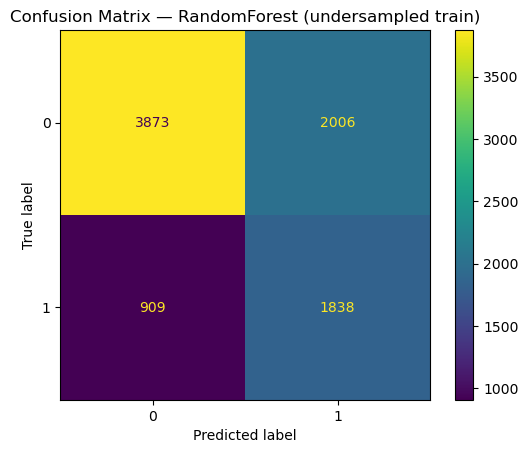

              precision    recall  f1-score   support

           0      0.810     0.659     0.727      5879
           1      0.478     0.669     0.558      2747

    accuracy                          0.662      8626
   macro avg      0.644     0.664     0.642      8626
weighted avg      0.704     0.662     0.673      8626



In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keep y as a Series so we can index by boolean masks
y = df["didnt_blank"]
X = df.drop(columns=["didnt_blank"])

# Split first (test set stays representative, not balanced)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- Random undersample majority class on TRAIN only ----
n_pos = (y_train == 1).sum()
pos_idx = y_train[y_train == 1].index
neg_idx = y_train[y_train == 0].index

# Sample equal number of negatives as positives
neg_idx_sample = np.random.default_rng(42).choice(neg_idx, size=n_pos, replace=False)

# Combine and shuffle
keep_idx = np.concatenate([pos_idx.values, neg_idx_sample])
rng = np.random.default_rng(42)
rng.shuffle(keep_idx)

X_train_bal = X_train.loc[keep_idx]
y_train_bal = y_train.loc[keep_idx]

print("Class counts (train before):", y_train.value_counts().to_dict())
print("Class counts (train after): ", y_train_bal.value_counts().to_dict())

# ---- Train model on balanced training set ----
clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train_bal, y_train_bal)

# ---- Evaluate on untouched test set ----
y_pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix — RandomForest (undersampled train)")
plt.show()

print(classification_report(y_test, y_pred, digits=3))



                            feature  importance
10                        influence    0.128053
12                         selected    0.107484
9                        creativity    0.064547
0                     n_games_in_gw    0.064385
11                           threat    0.062340
17          avg_points_when_playing    0.059583
20      avg_bps_p_game_when_playing    0.052218
2      playing_against_mean_defence    0.051997
4            playing_for_difficulty    0.040846
3       playing_against_mean_attack    0.039784
16         avg_minutes_when_playing    0.038892
7                              form    0.038262
23    avg_clean_sheets_when_playing    0.035403
24  avg_goals_conceded_when_playing    0.027949
6                playing_for_attack    0.026975
5               playing_for_defence    0.026740
1   playing_against_mean_difficulty    0.022453
18  avg_yellows_p_game_when_playing    0.020184
22  avg_assists_p_game_when_playing    0.017190
21    avg_goals_p_game_when_playing    0

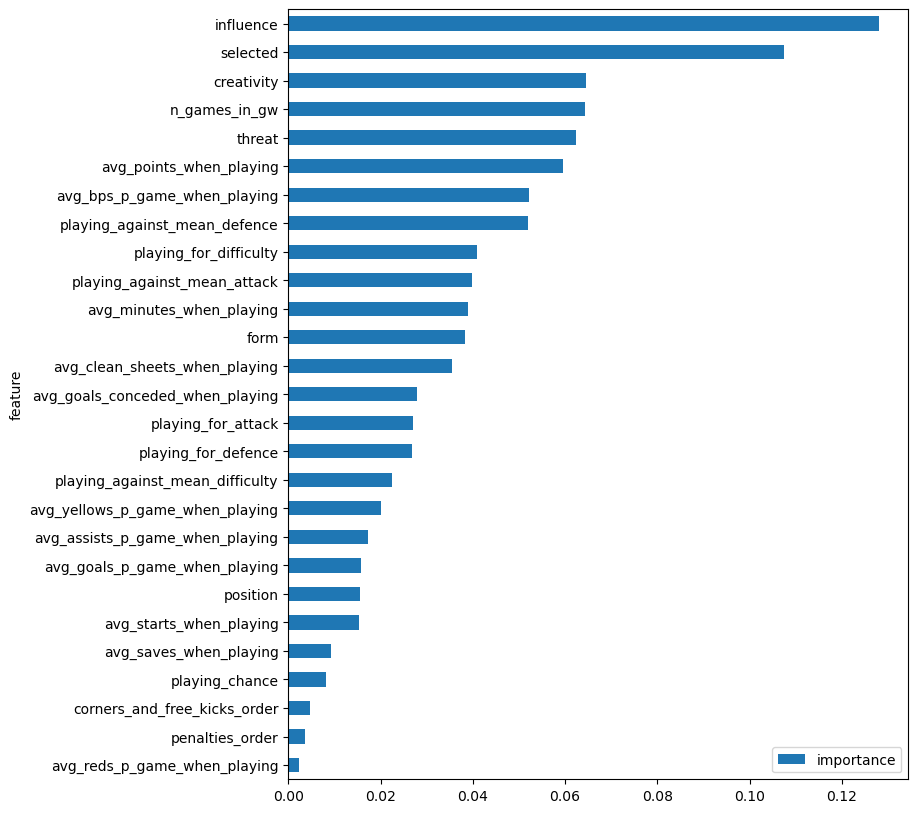

In [37]:
import pandas as pd
import numpy as np

importances = clf.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp_df.head(20))

feat_imp_df.plot(kind="barh", x="feature", y="importance", figsize=(8, 10))
plt.gca().invert_yaxis()
plt.show()


In [38]:
import joblib

# Save the trained model
joblib.dump(clf, "random_forest_model.pkl")

# Later, load it back
clf_loaded = joblib.load("random_forest_model.pkl")

# Verify it works
print(clf_loaded.predict(X_test[:5]))


[1 1 1 0 0]
